In [1]:
import pandas as pd
import numpy as np
import torch
import pickle
from umap import UMAP

import os
os.chdir('/data/yosef2/users/chenling/scVI/')

from scvi.inference import UnsupervisedTrainer, SemiSupervisedTrainer, AlternateSemiSupervisedTrainer
from scvi.models import VAE,SCANVI
from scvi.dataset import CsvDataset

# load dataset

In [2]:
rep=2
save_path = '/data/yosef2/users/chenling/symsim_scVI/symsim_result/continuous/'

In [3]:
cell_meta = pd.read_csv(save_path+'cell_meta.%i.csv'%rep)
cell_meta = cell_meta[['pop','depth']]

cell_meta['x'] = np.repeat(0, len(cell_meta['pop']))
cell_meta.loc[cell_meta['pop']=='6_1','x'] = 5
cell_meta.loc[cell_meta['pop']=='6_7','x'] = 3
cell_meta.loc[cell_meta['pop']=='7_9','x'] = 4
cell_meta.loc[cell_meta['pop']=='7_8','x'] = 2
cell_meta.loc[cell_meta['pop']=='9_4','x'] = 3.5
cell_meta.loc[cell_meta['pop']=='9_5','x'] = 4.5
cell_meta.loc[cell_meta['pop']=='8_2','x'] = 1.5
cell_meta.loc[cell_meta['pop']=='8_3','x'] = 2.5
dataset = CsvDataset("cont_obs.%i.csv"%rep,save_path=save_path,new_n_genes=5000)
bp = []
for x in np.unique(cell_meta['pop']):
    bp.append(np.max(cell_meta.loc[cell_meta['pop']==x]['depth']))

branchname, branch_id = np.unique(cell_meta['pop'],return_inverse=True)

cell_meta['branch_id'] = branch_id

samplename = 'cont_symsim.rep%i'%rep

File /data/yosef2/users/chenling/symsim_scVI/symsim_result/continuous/cont_obs.2.csv already downloaded
Preprocessing dataset
Finished preprocessing dataset


In [4]:
dataset.labels = branch_id
dataset.n_labels = len(np.unique(branch_id))
keys = np.unique(branch_id)


### Plotting parameters

In [5]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

jiggle = np.random.normal(0,0.1,len(cell_meta['x']))
import seaborn as sns
colors = sns.color_palette('tab10')

# Run this on simulation replicate 2

In [6]:
vae = VAE(dataset.nb_genes, n_batch=dataset.n_batches,
      n_hidden=128, n_latent=10, n_layers=2, dispersion='gene')
trainer = UnsupervisedTrainer(vae, dataset, train_size=1.0)

# if os.path.isfile(save_path+'models/vae.%s.pkl' % samplename ):
trainer.model.load_state_dict(torch.load(save_path+'models/vae.%s.pkl' % samplename))
trainer.model.eval()
# else:
# trainer.train(n_epochs=100)
# torch.save(trainer.model.state_dict(), save_path+'models/vae.%s.pkl'  % samplename)
    
full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)))

## Picking labeled sample from the tip of the branches and at the root

In [7]:

def label(x):
    if x['pop'] in ['6_1', '8_2', '8_3', '9_4', '9_5']:
        if x['depth']>(bp[x['branch_id']]-0.05):
            return True
        else:
            return False
    elif x['pop'] in ['6_7']:
        if x['depth']<0.05:
            return True
        else:
            return False
    else:
        return False
    
islabelled = []
for i in np.arange(cell_meta.shape[0]):
    islabelled.append(label(cell_meta.loc[i]))


cell_meta['islabelled'] = islabelled
branchname= np.unique(cell_meta['pop'])

In [8]:
# labelled_idx = np.random.choice(np.where(cell_meta['islabelled'] == True)[0],
#                                 np.sum(cell_meta['islabelled'] == True),
#                                 replace=False)
# unlabelled_idx = np.random.choice(np.where(cell_meta['islabelled'] == False)[0],
#                                 np.sum(cell_meta['islabelled'] == False),
#                                 replace=False)

# np.save(save_path + 'labelled_idx.npy', labelled_idx)
# np.save(save_path + 'unlabelled_idx.npy', unlabelled_idx)
labelled_idx = np.load(save_path+'labelled_idx.npy')
unlabelled_idx = np.load(save_path+'unlabelled_idx.npy')

# Run scMap

In [9]:
import numpy as np
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
from rpy2.rinterface import RRuntimeWarning
import gc
rpy2.robjects.numpy2ri.activate()
ro.r["library"]("scmap")
ro.r["library"]("SingleCellExperiment")
ro.r["library"]("matrixStats")
ro.r["library"]("Matrix")
ro.r["library"]("RcppCNPy")
ro.r["library"]("reticulate")


def runSCMAP(dataset, labelled_idx, unlabelled_idx):
    ro.r('rm(list=ls())')
    ro.r('gc()')
    gc.collect()
    n_features=100
    threshold =0
    #
    ro.r.assign("gene_names", ro.StrVector(dataset.gene_names))
    ro.r.assign("counts", ro.Matrix(dataset.X))
    ro.r.assign('labelled',ro.IntVector(labelled_idx))
    ro.r.assign('unlabelled',ro.IntVector(unlabelled_idx))
    n_samples = len(dataset)
    ro.r('counts <- t(counts)')
    ro.r("counts<-as.data.frame(as.matrix(counts), row.names=gene_names)")
    ro.r.assign("barcodes_cells", ro.StrVector(["cell_" + str(i) for i in range(n_samples)]))
    ro.r("colnames(counts)<-barcodes_cells")
    #
    ro.r.assign("labels", ro.StrVector(cell_meta['pop']))
    ro.r("labels<-as.data.frame(labels[labelled], row.names=barcodes_cells[labelled])")
    ro.r("colnames(labels)<-c('cell_type1')")
    ro.r("test <- SingleCellExperiment(assays=list(counts=as.matrix(counts[,unlabelled])),rowData=gene_names)")
    ro.r("train <- SingleCellExperiment(assays=list(counts=as.matrix(counts[,labelled])), colData=labels, rowData=gene_names)")
    #
    ro.r("rowData(train)$feature_symbol<-rownames(train)")
    ro.r("rowData(test)$feature_symbol<-rownames(test)")  
    ro.r("logcounts(train) <- log2(counts(train) + 1)")
    ro.r("logcounts(test) <- log2(counts(test) + 1)")
    ro.r("train<-selectFeatures(train,  n_features=500)")
    scmap_features = ro.r("rowData(train)$scmap_features")
    ro.r("train<-indexCluster(train)")
    ro.r("result<-scmapCluster(test, list(metadata(train)$scmap_cluster_index), threshold=0)")
    #
    scmap_probs = ro.r("result$scmap_cluster_siml")
    labels_pred = ro.r("result$scmap_cluster_labs")
    return (scmap_probs,labels_pred)

/data/yosef2/users/chenling/miniconda3/envs/pytorch_new/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in !value : invalid argument type

  warnings.warn(x, RRuntimeWarning)


LookupError: 'show' not found

In [ ]:
# scmap_probs,labels_pred = runSCMAP(dataset, labelled_idx, unlabelled_idx)

# scmap_res = pd.DataFrame([scmap_probs.ravel(),labels_pred.ravel()],
#                         ['prob','label']).T
# scmap_res.to_csv(save_path + 'scmap_res.csv')

In [42]:
scmap_res = pd.read_csv(save_path + 'scmap_res.csv')

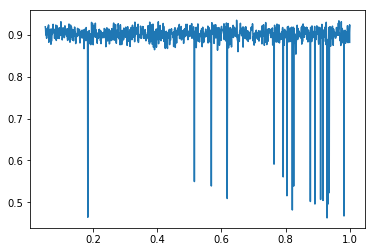

In [43]:
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][cell_meta['pop'][unlabelled_idx]=='6_7']),
                   np.asarray(scmap_res['prob'])[cell_meta['pop'][unlabelled_idx]=='6_7'].ravel()]).T
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1])

## training scVI 

### ground truth

In [11]:
labels = dataset.labels.ravel()
label_order = {'6_1':0, '6_7':1, '7_8':2, '7_9':3, '8_2':4, '8_3':5, '9_4':6,'9_5':7}
rev_dict = dict(zip([label_order[x] for x in label_order.keys()],label_order.keys()))
branch_id = np.asarray([label_order[x] for x in cell_meta['pop']])


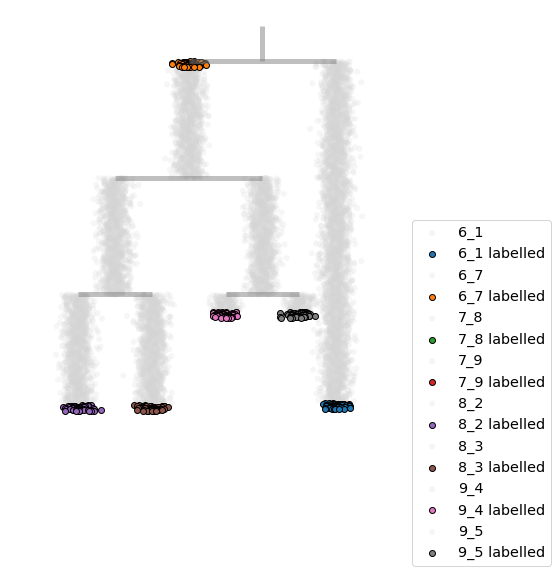

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
for i,k in enumerate(label_order.keys()):
    idx = (labels==i)
    ax.scatter((cell_meta['x']+jiggle)[idx], -cell_meta['depth'][idx], label=k,
               edgecolors='none',alpha=0.2,color='lightgray')
    idx = (labels==i)&(cell_meta['islabelled'] == True)
    ax.scatter((cell_meta['x']+jiggle)[idx], -cell_meta['depth'][idx], label=k+' labelled',
               edgecolors='black',color=colors[i])

plt.vlines(x=4, ymin=0.3,ymax=0, color='gray',linewidth=5.0,alpha=0.5)
plt.hlines(y=0, xmin=3,xmax=5, color='gray',linewidth=5.0,alpha=0.5)
plt.hlines(y=-1, xmin=2,xmax=4, color='gray',linewidth=5.0,alpha=0.5)
plt.hlines(y=-2, xmin=1.5,xmax=2.5, color='gray',linewidth=5.0,alpha=0.5)
plt.hlines(y=-2, xmin=3.5,xmax=4.5, color='gray',linewidth=5.0,alpha=0.5)

plt.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
plt.axis("off")
fig.tight_layout()
plt.savefig(save_path + 'simulation_truth.pdf')

# 8 classes, root labelled, just training the classifier

In [13]:
from scvi.models import Classifier
from scvi.inference.annotation import  ClassifierTrainer
classifier = Classifier(5000, n_labels=dataset.n_labels)
trainer = ClassifierTrainer(classifier, dataset)

trainer.train_set = trainer.create_posterior(indices=labelled_idx)

trainer.train(n_epochs=150, lr=1e-3)



training: 100%|██████████| 150/150 [00:04<00:00, 32.80it/s]


NameError: name 'rev_dict' is not defined

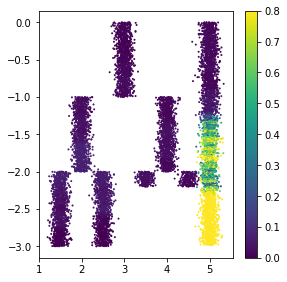

In [14]:
temp = trainer.compute_predictions(soft=True)
plt.figure(figsize=(20, 10))
for i in range(dataset.n_labels):
    plt.subplot(241 + i)
    plt.scatter(cell_meta['x']+jiggle, -cell_meta['depth'], c=np.asarray(temp[1][:,i]),
                       edgecolors='none', s=4, vmax=0.8,vmin=0)
    plt.colorbar()
    plt.title(rev_dict[i])
    plt.axis("off")
    plt.tight_layout()
    plt.vlines(x=4, ymin=0.3,ymax=0, color='gray',linewidth=5.0,alpha=0.5)
    plt.hlines(y=0, xmin=3,xmax=5, color='gray',linewidth=5.0,alpha=0.5)
    plt.hlines(y=-1, xmin=2,xmax=4, color='gray',linewidth=5.0,alpha=0.5)
    plt.hlines(y=-2, xmin=1.5,xmax=2.5, color='gray',linewidth=5.0,alpha=0.5)
    plt.hlines(y=-2, xmin=3.5,xmax=4.5, color='gray',linewidth=5.0,alpha=0.5)

plt.show()

In [39]:
# np.unique(labels_pred[cell_meta['pop'][unlabelled_idx]=='6_1'],return_counts=True)

### Root to tip 3 

In [ ]:
branches = ['6_7','7_9','8_3']
traj=[x in branches for x in cell_meta['pop'][unlabelled_idx]]
goodpred = [x=='6_7' for x in labels_pred[traj]]
i = 1

In [ ]:
tempy=np.asarray(scmap_probs[traj]).ravel()
tempy[np.asarray(goodpred)==False]=0
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   tempy]).T
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='c',alpha=0.9)

temp = trainer.compute_predictions(soft=True)
goodpred = np.asarray([np.argmax(x) for x in temp[1]])==i
goodpred = goodpred[unlabelled_idx][traj]
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   np.asarray(temp[1][:,i][unlabelled_idx][traj])]).T
temp[1][goodpred==False]=0
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='g',alpha=0.9)
plt.savefig(save_path+'root_3.rootprob.withcutoff.pdf')

In [ ]:
tempy=np.asarray(scmap_probs[traj]).ravel()
tempy[np.asarray(goodpred)==False]=0
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   tempy]).T
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='c',alpha=0.9)

temp = trainer.compute_predictions(soft=True)
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   np.asarray(temp[1][:,i][unlabelled_idx][traj])]).T

temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='g',alpha=0.9)
plt.savefig(save_path+'root_3.rootprob.pdf')

In [ ]:
branches = ['6_7','7_9','8_2']
traj=[x in branches for x in cell_meta['pop'][unlabelled_idx]]
goodpred = [x=='8_2' for x in labels_pred[traj]]
i = 4

tempy=np.asarray(scmap_probs[traj]).ravel()
tempy[np.asarray(goodpred)==False]=0
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   tempy]).T
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='c',alpha=0.9)

temp = trainer.compute_predictions(soft=True)
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   np.asarray(temp[1][:,i][unlabelled_idx][traj])]).T
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='g',alpha=0.9)
plt.savefig(save_path+'root_2.2prob.pdf')

In [ ]:
tempy=np.asarray(scmap_probs[traj]).ravel()
tempy[np.asarray(goodpred)==False]=0
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   tempy]).T
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='c',alpha=0.9)

temp = trainer.compute_predictions(soft=True)
goodpred = np.asarray([np.argmax(x) for x in temp[1]])==i
goodpred = goodpred[unlabelled_idx][traj]
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   np.asarray(temp[1][:,i][unlabelled_idx][traj])]).T
temp[1][goodpred==False]=0
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='g',alpha=0.9)
plt.savefig(save_path+'root_2.2prob.withcutoff.pdf')

# 6 classes, root labelled, just training the classifier

In [ ]:
label_order = {'6_1':1, '6_7':0, '7_8':0, '7_9':0, '8_2':2, '8_3':3, '9_4':4,'9_5':5}
rev_dict = dict(zip([label_order[x] for x in label_order.keys()],label_order.keys()))
branch_id = np.asarray([label_order[x] for x in cell_meta['pop']])

dataset.labels = branch_id
dataset.n_labels = len(np.unique(branch_id))
keys = np.unique(branch_id)

from scvi.inference.annotation import ClassifierTrainer
from scvi.models.classifier import Classifier

classifier = Classifier(5000, n_labels=dataset.n_labels)
trainer = ClassifierTrainer(classifier, dataset)
trainer.train_set = trainer.create_posterior(indices=labelled_idx)

trainer.train(n_epochs=150, lr=1e-3)



In [ ]:
temp = trainer.compute_predictions(soft=True)
plt.figure(figsize=(20, 10))
for i in range(dataset.n_labels):
    plt.subplot(241 + i)
    plt.scatter(cell_meta['x']+jiggle, -cell_meta['depth'], c=np.asarray(temp[1][:,i]),
                       edgecolors='none', s=4, vmax=0.5,vmin=0)
    plt.colorbar()
    plt.title(rev_dict[i])
    plt.axis("off")
    plt.tight_layout()
    plt.vlines(x=4, ymin=0.3,ymax=0, color='gray',linewidth=5.0,alpha=0.5)
    plt.hlines(y=0, xmin=3,xmax=5, color='gray',linewidth=5.0,alpha=0.5)
    plt.hlines(y=-1, xmin=2,xmax=4, color='gray',linewidth=5.0,alpha=0.5)
    plt.hlines(y=-2, xmin=1.5,xmax=2.5, color='gray',linewidth=5.0,alpha=0.5)
    plt.hlines(y=-2, xmin=3.5,xmax=4.5, color='gray',linewidth=5.0,alpha=0.5)

plt.show()

### Root to tip 3 

In [ ]:
branches = ['6_7','7_9','8_3']
traj=[x in branches for x in cell_meta['pop'][unlabelled_idx]]
goodpred = [x=='6_7' for x in labels_pred[traj]]
i = 0

In [ ]:
tempy=np.asarray(scmap_probs[traj]).ravel()
tempy[np.asarray(goodpred)==False]=0
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   tempy]).T
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='c',alpha=0.9)

temp = trainer.compute_predictions(soft=True)
goodpred = np.asarray([np.argmax(x) for x in temp[1]])==i
goodpred = goodpred[unlabelled_idx][traj]
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   np.asarray(temp[1][:,i][unlabelled_idx][traj])]).T
temp[1][goodpred==False]=0
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='g',alpha=0.9)
plt.savefig(save_path+'root_3.rootprob.withcutoff.6_classes.pdf')

In [ ]:
tempy=np.asarray(scmap_probs[traj]).ravel()
tempy[np.asarray(goodpred)==False]=0
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   tempy]).T
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='c',alpha=0.9)

temp = trainer.compute_predictions(soft=True)
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   np.asarray(temp[1][:,i][unlabelled_idx][traj])]).T

temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='g',alpha=0.9)
plt.savefig(save_path+'root_3.rootprob.6_classes.pdf')

In [ ]:
branches = ['6_7','7_9','8_2']
traj=[x in branches for x in cell_meta['pop'][unlabelled_idx]]
goodpred = [x=='8_2' for x in labels_pred[traj]]
i = 2

tempy=np.asarray(scmap_probs[traj]).ravel()
tempy[np.asarray(goodpred)==False]=0
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   tempy]).T
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='c',alpha=0.9)

temp = trainer.compute_predictions(soft=True)
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   np.asarray(temp[1][:,i][unlabelled_idx][traj])]).T
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='g',alpha=0.9)
plt.savefig(save_path+'root_2.2prob.6_classes.pdf')

In [ ]:
tempy=np.asarray(scmap_probs[traj]).ravel()
tempy[np.asarray(goodpred)==False]=0
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   tempy]).T
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='c',alpha=0.9)

temp = trainer.compute_predictions(soft=True)
goodpred = np.asarray([np.argmax(x) for x in temp[1]])==i
goodpred = goodpred[unlabelled_idx][traj]
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   np.asarray(temp[1][:,i][unlabelled_idx][traj])]).T
temp[1][goodpred==False]=0
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='g',alpha=0.9)
plt.savefig(save_path+'root_2.2prob.withcutoff.6_classes.pdf')

# run SCANVI with 8 labels

In [40]:
label_order = {'6_1':0, '6_7':1, '7_8':2, '7_9':3, '8_2':4, '8_3':5, '9_4':6,'9_5':7}
rev_dict = dict(zip([label_order[x] for x in label_order.keys()],label_order.keys()))
branch_id = np.asarray([label_order[x] for x in cell_meta['pop']])

dataset.labels = branch_id
dataset.n_labels = len(np.unique(branch_id))
keys = np.unique(branch_id)


In [42]:
# scmap_probs,labels_pred = runSCMAP(dataset, labelled_idx, unlabelled_idx)

In [43]:
scanvi = SCANVI(dataset.nb_genes, dataset.n_batches, dataset.n_labels, n_layers=2,  
                                       classifier_parameters = {'dropout_rate':0.1, 'n_hidden':128, 'n_layers':1})

scanvi.load_state_dict(trainer.model.state_dict(), strict=False)
trainer_scanvi = SemiSupervisedTrainer(scanvi, dataset, classification_ratio=8,
                                       n_epochs_classifier=30, lr_classification=5 * 1e-3)


trainer_scanvi.labelled_set = trainer_scanvi.create_posterior(indices=labelled_idx)
trainer_scanvi.unlabelled_set = trainer_scanvi.create_posterior(indices=unlabelled_idx)

trainer_scanvi.train(n_epochs=9)

training: 100%|██████████| 9/9 [00:32<00:00,  3.60s/it]


In [44]:
full_scanvi = trainer_scanvi.create_posterior(trainer_scanvi.model, dataset, indices=np.arange(len(dataset)))
all_y_pred_prob = []
for i_batch, tensors in enumerate(full_scanvi.sequential(batch_size=1)):
    sample_batch, _, _, _, _ = tensors
    all_y_pred_prob += [full_scanvi.model.classify_prob(sample_batch)]

AttributeError: 'SCANVI' object has no attribute 'classify_prob'

In [ ]:
prob = [torch.cat(x).mean(0).detach().cpu().numpy() for x in all_y_pred_prob]
prob = np.asarray(prob)

maxprob = [np.max(x) for x in prob]
sum(np.asarray(maxprob)<0.8)/len(maxprob)

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(dataset.n_labels):
    plt.subplot(241 + i)
    plt.scatter(cell_meta['x']+jiggle, -cell_meta['depth'], c=np.asarray(prob[:,i]),
                       edgecolors='none', s=4, vmax=0.5,vmin=0)
    plt.colorbar()
    plt.title(rev_dict[i])
    plt.axis("off")
    plt.tight_layout()
    plt.vlines(x=4, ymin=0.3,ymax=0, color='gray',linewidth=5.0,alpha=0.5)
    plt.hlines(y=0, xmin=3,xmax=5, color='gray',linewidth=5.0,alpha=0.5)
    plt.hlines(y=-1, xmin=2,xmax=4, color='gray',linewidth=5.0,alpha=0.5)
    plt.hlines(y=-2, xmin=1.5,xmax=2.5, color='gray',linewidth=5.0,alpha=0.5)
    plt.hlines(y=-2, xmin=3.5,xmax=4.5, color='gray',linewidth=5.0,alpha=0.5)

plt.show()

### Root to tip 3 

In [ ]:
branches = ['6_7','7_9','8_3']
traj=[x in branches for x in cell_meta['pop'][unlabelled_idx]]
goodpred = [x=='6_7' for x in labels_pred[traj]]
i = 1

In [ ]:
tempy=np.asarray(scmap_probs[traj]).ravel()
tempy[np.asarray(goodpred)==False]=0
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   tempy]).T
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='c',alpha=0.9)

# temp = trainer.compute_predictions(soft=True)
goodpred = np.asarray([np.argmax(x) for x in prob])==i
goodpred = goodpred[unlabelled_idx][traj]
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   np.asarray(prob[:,i][unlabelled_idx][traj])]).T
temp[1][goodpred==False]=0
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='g',alpha=0.9)
plt.savefig(save_path+'root_3.rootprob.withcutoff.scanvi.pdf')

In [ ]:
tempy=np.asarray(scmap_probs[traj]).ravel()
tempy[np.asarray(goodpred)==False]=0
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   tempy]).T
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='c',alpha=0.9)

# temp = trainer_scanvi.classifier_trainer.compute_predictions(soft=True)
temp=[0,prob]
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   np.asarray(temp[1][:,i][unlabelled_idx][traj])]).T

temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='g',alpha=0.9)
plt.savefig(save_path+'root_3.rootprob.scanvi.pdf')

In [ ]:
branches = ['6_7','7_9','8_2']
traj=[x in branches for x in cell_meta['pop'][unlabelled_idx]]
goodpred = [x=='8_2' for x in labels_pred[traj]]
i = 4

tempy=np.asarray(scmap_probs[traj]).ravel()
tempy[np.asarray(goodpred)==False]=0
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   tempy]).T
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='c',alpha=0.9)

# temp = trainer_scanvi.classifier_trainer.compute_predictions(soft=True)
temp=[0,prob]
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   np.asarray(temp[1][:,i][unlabelled_idx][traj])]).T
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='g',alpha=0.9)
plt.savefig(save_path+'root_2.2prob.scanvi.pdf')

In [ ]:
tempy=np.asarray(scmap_probs[traj]).ravel()
tempy[np.asarray(goodpred)==False]=0
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   tempy]).T
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='c',alpha=0.9)

# temp = trainer_scanvi.classifier_trainer.compute_predictions(soft=True)
temp=[0,prob]
goodpred = np.asarray([np.argmax(x) for x in temp[1]])==i
goodpred = goodpred[unlabelled_idx][traj]
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   np.asarray(temp[1][:,i][unlabelled_idx][traj])]).T
temp[1][goodpred==False]=0
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='g',alpha=0.9)
plt.savefig(save_path+'root_2.2prob.withcutoff.scanvi.pdf')

# train SCANVI with less classes

In [15]:
label_order = {'6_1':1, '6_7':0, '7_8':0, '7_9':0, '8_2':2, '8_3':3, '9_4':4,'9_5':5}
rev_dict = dict(zip([label_order[x] for x in label_order.keys()],label_order.keys()))
branch_id = np.asarray([label_order[x] for x in cell_meta['pop']])

dataset.labels = branch_id
dataset.n_labels = len(np.unique(branch_id))
keys = np.unique(branch_id)


In [16]:
scanvi = SCANVI(dataset.nb_genes, dataset.n_batches, dataset.n_labels, n_layers=2,  
                                       classifier_parameters = {'dropout_rate':0.1, 'n_hidden':128, 'n_layers':1})

scanvi.load_state_dict(trainer.model.state_dict(), strict=False)
trainer_scanvi = SemiSupervisedTrainer(scanvi, dataset, classification_ratio=8,
                                       n_epochs_classifier=30, lr_classification=5 * 1e-3)


trainer_scanvi.labelled_set = trainer_scanvi.create_posterior(indices=labelled_idx)
trainer_scanvi.unlabelled_set = trainer_scanvi.create_posterior(indices=unlabelled_idx)

trainer_scanvi.train(n_epochs=9)

training: 100%|██████████| 9/9 [00:33<00:00,  3.60s/it]


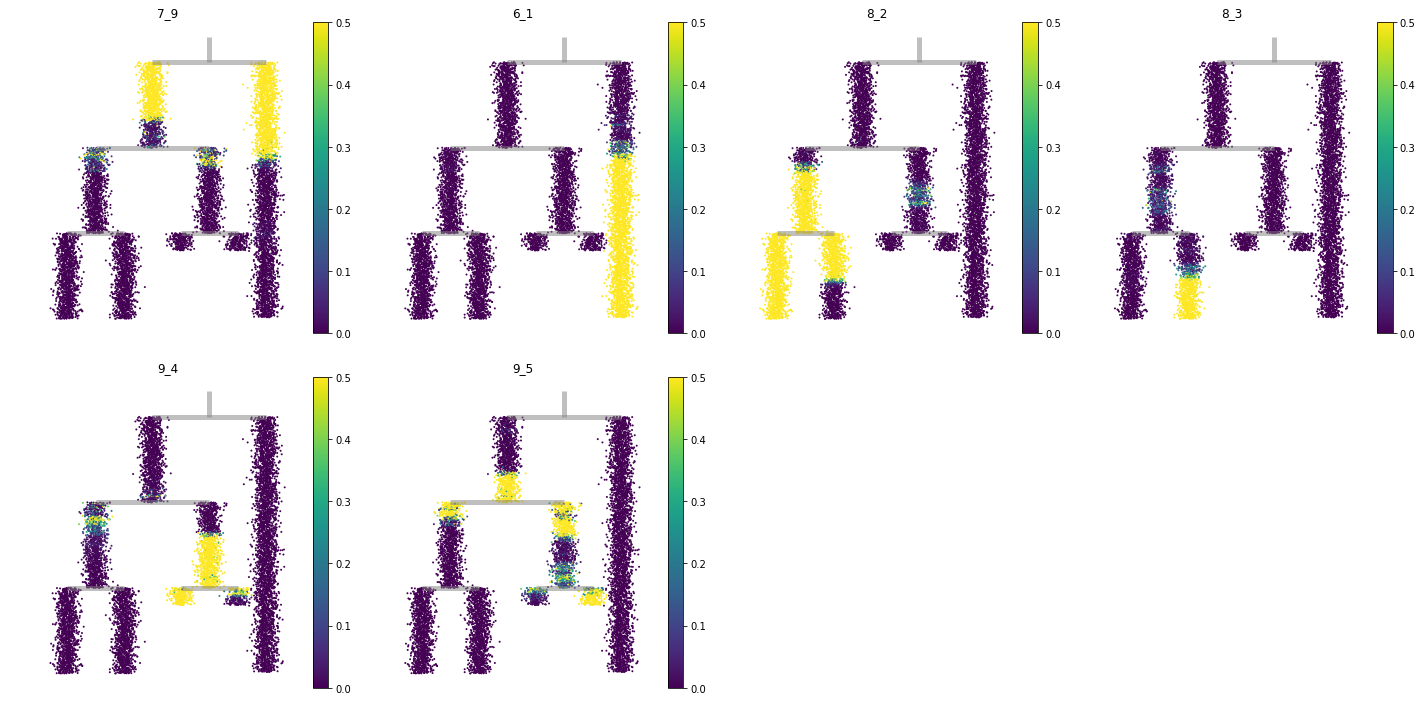

In [17]:
temp = trainer_scanvi.classifier_trainer.compute_predictions(soft=True)
plt.figure(figsize=(20, 10))
for i in range(dataset.n_labels):
    plt.subplot(241 + i)
    plt.scatter(cell_meta['x']+jiggle, -cell_meta['depth'], c=np.asarray(temp[1][:,i]),
                       edgecolors='none', s=4, vmax=0.5,vmin=0)
    plt.colorbar()
    plt.title(rev_dict[i])
    plt.axis("off")
    plt.tight_layout()
    plt.vlines(x=4, ymin=0.3,ymax=0, color='gray',linewidth=5.0,alpha=0.5)
    plt.hlines(y=0, xmin=3,xmax=5, color='gray',linewidth=5.0,alpha=0.5)
    plt.hlines(y=-1, xmin=2,xmax=4, color='gray',linewidth=5.0,alpha=0.5)
    plt.hlines(y=-2, xmin=1.5,xmax=2.5, color='gray',linewidth=5.0,alpha=0.5)
    plt.hlines(y=-2, xmin=3.5,xmax=4.5, color='gray',linewidth=5.0,alpha=0.5)

plt.show()

In [18]:
full_scanvi = trainer_scanvi.create_posterior(trainer_scanvi.model, dataset, indices=np.arange(len(dataset)))
all_y_pred_prob = []
for i_batch, tensors in enumerate(full_scanvi.sequential(batch_size=1)):
    sample_batch, _, _, _, _ = tensors
    all_y_pred_prob += [full_scanvi.model.classify_prob(sample_batch)]

In [19]:
torch.cat(all_y_pred_prob[0]).shape

torch.Size([10, 6])

In [20]:
prob = [torch.cat(x).mean(0).detach().cpu().numpy() for x in all_y_pred_prob]
prob = np.asarray(prob)

maxprob = [np.max(x) for x in prob]
sum(np.asarray(maxprob)<0.8)/len(maxprob)

0.4354

In [21]:
prob.shape

(10000, 6)

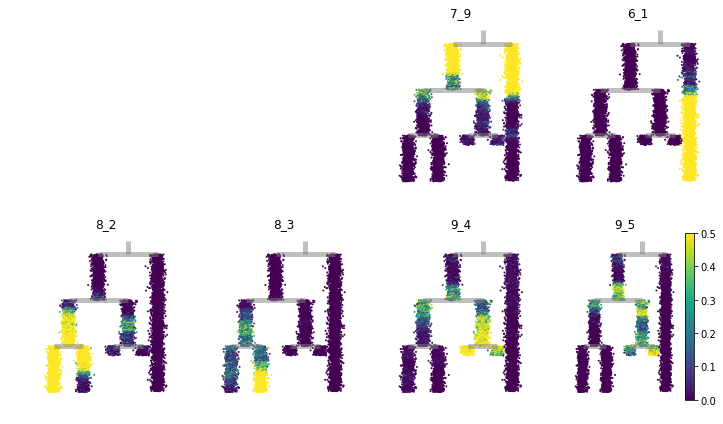

In [22]:
plt.figure(figsize=(10, 6))
for i in range(dataset.n_labels):
    plt.subplot(241 + i + 2)
    plt.scatter(cell_meta['x']+jiggle, -cell_meta['depth'], c=np.asarray(prob[:,i]),
                       edgecolors='none', s=4, vmax=0.5,vmin=0)
    plt.title(rev_dict[i])
    plt.axis("off")
    plt.tight_layout()
    plt.vlines(x=4, ymin=0.3,ymax=0, color='gray',linewidth=5.0,alpha=0.5)
    plt.hlines(y=0, xmin=3,xmax=5, color='gray',linewidth=5.0,alpha=0.5)
    plt.hlines(y=-1, xmin=2,xmax=4, color='gray',linewidth=5.0,alpha=0.5)
    plt.hlines(y=-2, xmin=1.5,xmax=2.5, color='gray',linewidth=5.0,alpha=0.5)
    plt.hlines(y=-2, xmin=3.5,xmax=4.5, color='gray',linewidth=5.0,alpha=0.5)

plt.colorbar()
plt.savefig(save_path+'prob_colors.pdf')

### Root to tip 3 

In [44]:
scmap_probs = np.asarray(scmap_res['prob'])
labels_pred = np.asarray(scmap_res['label'])

In [45]:
branches = ['6_7','7_9','8_3']
traj=[x in branches for x in cell_meta['pop'][unlabelled_idx]]
goodpred = [x=='6_7' for x in labels_pred[traj]]
i = 0

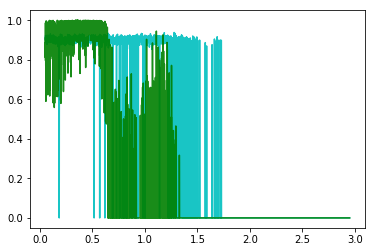

In [46]:
tempy=np.asarray(scmap_probs[traj]).ravel()
tempy[np.asarray(goodpred)==False]=0
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   tempy]).T
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='c',alpha=0.9)

# temp = trainer.compute_predictions(soft=True)
goodpred = np.asarray([np.argmax(x) for x in prob])==i
goodpred = goodpred[unlabelled_idx][traj]
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   np.asarray(prob[:,i][unlabelled_idx][traj])]).T
temp[1][goodpred==False]=0
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='g',alpha=0.9)
plt.savefig(save_path+'root_3.rootprob.withcutoff.scanvi.6_classes.pdf')

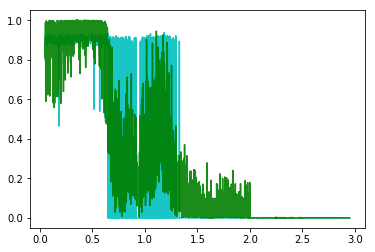

In [47]:
tempy=np.asarray(scmap_probs[traj]).ravel()
tempy[np.asarray(goodpred)==False]=0
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   tempy]).T
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='c',alpha=0.9)

# temp = trainer_scanvi.classifier_trainer.compute_predictions(soft=True)
temp=[0,prob]
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   np.asarray(temp[1][:,i][unlabelled_idx][traj])]).T

temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='g',alpha=0.9)
plt.savefig(save_path+'root_3.rootprob.scanvi.6_classes.pdf')

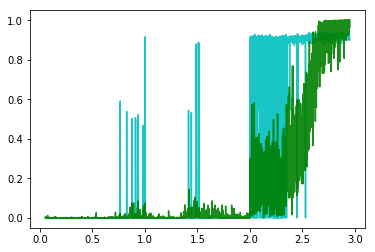

In [48]:
branches = ['6_7','7_9','8_3']
traj=[x in branches for x in cell_meta['pop'][unlabelled_idx]]
goodpred = [x=='8_3' for x in labels_pred[traj]]
i = 3

tempy=np.asarray(scmap_probs[traj]).ravel()
tempy[np.asarray(goodpred)==False]=0
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   tempy]).T
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='c',alpha=0.9)

# temp = trainer_scanvi.classifier_trainer.compute_predictions(soft=True)
temp=[0,prob]
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   np.asarray(temp[1][:,i][unlabelled_idx][traj])]).T
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='g',alpha=0.9)
plt.savefig(save_path+'root_3.3prob.scanvi.6_classes.pdf')

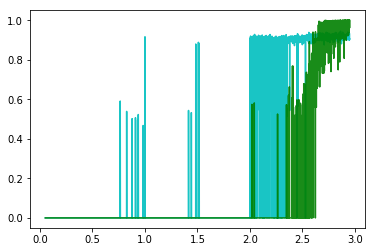

In [49]:
tempy=np.asarray(scmap_probs[traj]).ravel()
tempy[np.asarray(goodpred)==False]=0
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   tempy]).T
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='c',alpha=0.9)

temp=[0,prob]
goodpred = np.asarray([np.argmax(x) for x in temp[1]])==i
goodpred = goodpred[unlabelled_idx][traj]
temp = pd.DataFrame([np.asarray(cell_meta['depth'][unlabelled_idx][traj]),
                   np.asarray(temp[1][:,i][unlabelled_idx][traj])]).T
temp[1][goodpred==False]=0
temp = temp.sort_values(by=0)
plt.plot(temp[0],temp[1],color='g',alpha=0.9)
plt.savefig(save_path+'root_3.3prob.withcutoff.scanvi.6_classes.pdf')

In [54]:
temp = trainer_scanvi.classifier_trainer.compute_predictions(soft=True)


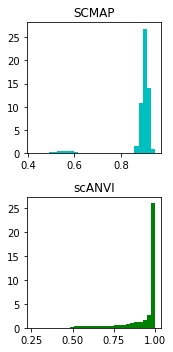

In [80]:
plt.figure(figsize=(2.5,5))
plt.subplot(211)
plt.hist(scmap_probs,color='c',alpha=1,bins=30,density=True)
plt.title('SCMAP')
plt.subplot(212)
plt.hist(temp[1].max(axis=1),color='g',alpha=1,bins=30,density=True)
plt.title('scANVI')
plt.tight_layout()
plt.savefig(save_path+'continuous_sim.hist.pdf')

In [ ]:
from scipy.stats import spearmanr

In [ ]:
r1 = spearmanr(np.asarray(cell_meta['depth'][unlabelled_idx][traj]),np.asarray(prob[:,0][unlabelled_idx][traj]))
r2 = spearmanr(np.asarray(cell_meta['depth'][unlabelled_idx][traj]),np.asarray(prob[:,3][unlabelled_idx][traj]))


In [ ]:
r2

In [ ]:
r1